# Классификация комментариев

Задачу классификации текстов можно решить, используя следующий пайплайн:
1. Предобработка данных
2. Получение эмбеддингов предложений
3. Обработка эмбеддингов с помощью бинарного классификатора
4. Оценка точности модели

В качестве модели предлагаю использовать одну из версий BERT, наиболее легковесную. В соответствии с пайпланом на выходе с BERT должен находиться линейный классификатор с одним выходом и двумя вариантами ответа. Для получения высокой точности предсказаний, предлагаю провести дообучение модели на имеющихся данных.

Для запуска уже обученной модели, прокрутите ноутбук в самый низ.

[Модель: cointegrated/rubert-tiny](https://huggingface.co/cointegrated/rubert-tiny)

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

### pyTorch: DataSet
Подготовленный тип данных на базе torch.dataset, с обработкой текста токенизатором БЕРТа

In [2]:
class CustomDataset(Dataset):

    def __init__(self, texts, targets, tokenizer, max_len=512):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        target = self.targets[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

### pyTorch + transformers: BertClassifier
Обертка над BertForSequenceClassification с train\predict методами

In [3]:
class BertClassifier:

    def __init__(self, model_path, tokenizer_path, epochs=2, batch_size=5, n_classes=2, model_save_path='bert.pt'):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path = model_save_path
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid):
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=5, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=5, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * self.epochs
        )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in self.train_loader:
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss

    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def train(self):
        best_accuracy = 0
        train_acc_array = []
        val_acc_arrat = []
        train_loss_array = []
        val_loss_array = []
        for epoch in range(self.epochs):
            start_time = time.time()
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print(f'Epoch time {time.time() - start_time}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc
            train_acc_array.append(train_acc.cpu().numpy())
            val_acc_arrat.append(val_acc.cpu().numpy())
            train_loss_array.append(train_loss)
            val_loss_array.append(val_loss)

        self.model = torch.load(self.model_save_path)
        return train_acc_array, val_acc_arrat, train_loss_array, val_loss_array

    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )

        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

### Предобработка


In [4]:
train_df=pd.read_csv('train_tin.csv', encoding="cp1251", sep=',',header=0)
train_df.head()

,text,isPositive
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0
1,Добрый день! Неоднократно поступают звонки по ...,0
2,В первый раз решила воспользоваться кредитной ...,0
3,На самом дело уже накипело из-за участившегося...,0
4,Если вы дорожите своими нервами - ни при каких...,0


In [5]:
test_df=pd.read_csv('test_tin.csv', encoding="cp1251", sep=',',header=0)
test_df.head()

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,NaN
1,Хочу выразить огромную благодарность банку Тин...,NaN
2,Выражаю благодарность К-ву Александру В. за ст...,NaN
3,В январе 2019 года оформила потребительский кр...,NaN
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,NaN


Для дообучения Берта, ему на вход, помимо самих данных, должны попасть токенизированныепоследовательности символов. Размерностью не превышающие 512 токенов. Соответственно, нужно разбить тексты обучающей выборки на части длинной не более 512 симоволов.
Label для каждой такой последовательности будет дублироваться из основного комментария.

In [6]:
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(len(train_df)):
    tmp = train_df['text'].values[i]
    while len(tmp) > 0:
        x_train.append(tmp[:512])
        y_train.append(train_df['isPositive'].values[i])
        tmp = tmp[512:]

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                      test_size=0.2,
                                                      random_state=4)

### Fine-tune tiny BERT

In [8]:
epochs = 2
batch_size = 1
classifier = BertClassifier(
    model_path='cointegrated/rubert-tiny',
    tokenizer_path='cointegrated/rubert-tiny',
    epochs=epochs,
    batch_size=batch_size,
    n_classes=2,
    model_save_path='bert.pt'
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [9]:
classifier.preparation(X_train=x_train, y_train=y_train,
                       X_valid=x_valid, y_valid=y_valid)

При обучении модели, больше чем 1-2 эпохи, она в значительной степени переобучается, и хотя это почти не вляет на валидационную часть данных: за 10 эпох, значение accuracy зависло около 0.88, зато потери возросли с 0.4 до 1.

In [10]:
history = classifier.train()

Epoch 1/2
Train loss 0.4079897329870106 accuracy 0.8384752677205508
Val loss 0.3837363056041082 accuracy 0.8710499490316005
Epoch time 98.23680686950684
----------
Epoch 2/2
Train loss 0.34677623533529517 accuracy 0.8841152473227946
Val loss 0.41252072049990895 accuracy 0.8756371049949032
Epoch time 96.97204041481018
----------


([<matplotlib.axis.XTick at 0x2218fa952b0>,
 [Text(0, 0, ''), Text(0, 0, '')])

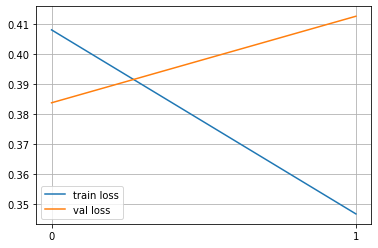

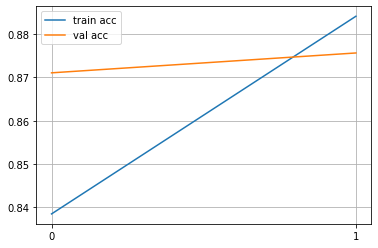

In [11]:
plt.figure()
plt.plot(history[2], label='train loss')
plt.plot(history[3], label='val loss')
plt.legend(loc='best')
plt.grid()
plt.xticks(range(0,epochs))
plt.figure()
plt.plot(history[0], label='train acc')
plt.plot(history[1], label='val acc')
plt.legend(loc='best')
plt.grid()
plt.xticks(range(0,epochs))

### Predict on full train sentences

In [12]:
texts = train_df['text'].values[:50]
labels = train_df['isPositive'].values[:50]

### Predict

In [13]:
texts = test_df['text'].values
labels = test_df['isPositive'].values
predictions = [classifier.predict(t) for t in texts]

# Use model from file

In [14]:
import torch
import pandas as pd
import numpy as np

In [15]:
def predict(tokenizer, model, text):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        return_token_type_ids=False,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    out = {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten()
    }

    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)

    outputs = model(
        input_ids=input_ids.unsqueeze(0),
        attention_mask=attention_mask.unsqueeze(0)
    )

    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

    return prediction

In [16]:
tokenizer = BertTokenizer.from_pretrained('cointegrated/rubert-tiny')
model = torch.load('bert.pt')

In [17]:
test_df=pd.read_csv('train_tin.csv', encoding="cp1251", sep=',',header=0)
texts = test_df['text'].values
labels = test_df['isPositive'].values
predictions = [predict(tokenizer, model, t) for t in texts]
error_fl = False
error_counter = 0
for i in range(len(labels)):
    if labels[i] != predictions[i]:
        error_fl = True
        error_counter += 1
        print(f'#{i}, label={labels[i]}, pred={predictions[i]}')
if not error_fl:
    print('All answers are correct')
else:
    print(f'There is {error_counter} errors in {len(labels)} comments')

#47, label=0, pred=1
#207, label=0, pred=1
#362, label=0, pred=1
#374, label=0, pred=1
#484, label=0, pred=1
#492, label=0, pred=1
#546, label=0, pred=1
#554, label=0, pred=1
#569, label=0, pred=1
#719, label=0, pred=1
#748, label=0, pred=1
#800, label=0, pred=1
#860, label=0, pred=1
#868, label=0, pred=1
#885, label=0, pred=1
#896, label=0, pred=1
#909, label=0, pred=1
#952, label=0, pred=1
#998, label=0, pred=1
#1244, label=0, pred=1
#1263, label=0, pred=1
#1361, label=0, pred=1
#1383, label=0, pred=1
#1392, label=0, pred=1
#1425, label=0, pred=1
#1539, label=0, pred=1
#1613, label=0, pred=1
#1665, label=0, pred=1
#1684, label=0, pred=1
#1697, label=0, pred=1
#1816, label=0, pred=1
#1818, label=0, pred=1
#1938, label=0, pred=1
#1976, label=1, pred=0
#1980, label=1, pred=0
#1987, label=1, pred=0
#1998, label=1, pred=0
#2001, label=1, pred=0
#2004, label=1, pred=0
#2010, label=1, pred=0
#2016, label=1, pred=0
#2025, label=1, pred=0
#2026, label=1, pred=0
#2031, label=1, pred=0
#2049, l

In [18]:
test_df=pd.read_csv('test_tin.csv', encoding="cp1251", sep=',',header=0)
texts = test_df['text'].values
predictions = [predict(tokenizer, model, t) for t in texts]
df_out = pd.DataFrame({'text':texts, 'isPositive':predictions})

In [19]:
df_out

,text,isPositive
0,Добрый день! Я являюсь клиентом Тинькофф банк ...,0
1,Хочу выразить огромную благодарность банку Тин...,1
2,Выражаю благодарность К-ву Александру В. за ст...,1
3,В январе 2019 года оформила потребительский кр...,0
4,Добрый день. Хочу поблагодарить банк Тинькофф ...,1
...,...,...
995,Приветствую! 18.02 хотел совершить несколько п...,0
996,Сотрудник Шахноза (6904552) очень грамотно и б...,1
997,"Добрый день!Я являюсь клиентом банка, теперь у...",0
998,Столкнулись с проблемой: нужно было провести п...,1
